<a href="https://colab.research.google.com/github/eric-sun92/pytorch_intro/blob/01_pytorch_workflow/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import sklearn

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)


In [53]:
print(f"first 5 samples of X:\n {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")


first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


In [54]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


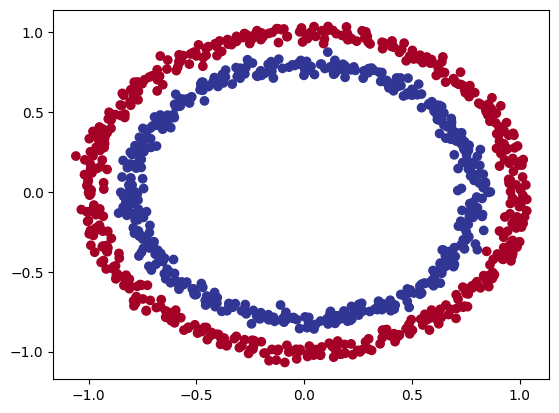

In [55]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], 
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [56]:
# note: the data we are working with is often reffered to as a toy data set

In [57]:
# turn data from numpy to tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.to(device)
y_test = y_test.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)


len(X_train), len(X_test)

(800, 200)

In [60]:
torch.manual_seed(42)

# build model to classify red/blue dots

# 1. setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. construct a model (by subclassing nn.Module)

1. Subclass of nn.Module
2. Create nn.Linear() layers that are capable of handling the shapes of our data
3. Define forward() function that outlines forward pass/computation of model
4. instantiate an instance of our model class and send it to target device 


In [61]:
from sklearn import model_selection
from torch import nn
torch.manual_seed(42)

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_02 = CircleModelV0()

model_02.to(device)

model_2 = nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_2.state_dict()



OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [62]:
# make predictions
model_2.to(device)

model_2.eval()
with torch.inference_mode():
  untrained_y = model_2(X_test.to(device))

print(f"length of predictions:{len(untrained_y)}, Shape: {untrained_y.shape}")
print(f"length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"First 10 predictions: {untrained_y[:10]}")
print(f"First 10 labels: {y_test[:10]}")



length of predictions:200, Shape: torch.Size([200, 1])
length of test samples: 200, Shape: torch.Size([200, 2])
First 10 predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')


In [63]:
# setup loss function
# loss_fn = nn.BCELoss() # requires inputs to have gone through sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built in

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)



In [64]:
# calcualte accuracy

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc


In [65]:
# train model

# go from raw logit -> prediction probabilities -> prediction labels

# model output will be raw logits -> pass through activation function
# (for Binary cross entropy - sigmoid, for multiclassification - softmax)
# convert to prediction labels using round or argmax

model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_test.to(device))[:5]

y_pred_probs = torch.sigmoid(y_logits)

In [66]:
y_preds = torch.round(y_pred_probs)

# can just do all that in one line
y_pred_labels = torch.round(torch.sigmoid(model_2(X_test.to(device))))
y_pred_labels.squeeze()

tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [73]:
#building the training and test loop

num_epochs = 200
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(num_epochs):

  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, 
                 y_train)
  
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_02.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                  y_test)

    test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_pred)

  if epoch % 20 == 0:
    print(f"epoch: {epoch} - Loss: {loss}, Accuracy: {acc} | testLoss: {test_loss}, testAcc: {test_acc}")


epoch: 0 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946455240249634, testAcc: 45.0
epoch: 20 - Loss: 0.6929799318313599, Accuracy: 51.24999999999999 | testLoss: 0.6946479678153992, testAcc: 45.0
epoch: 40 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946502327919006, testAcc: 45.0
epoch: 60 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946523189544678, testAcc: 45.0
epoch: 80 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946543455123901, testAcc: 45.0
epoch: 100 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946561336517334, testAcc: 45.0
epoch: 120 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.6946578621864319, testAcc: 45.5
epoch: 140 - Loss: 0.6929798722267151, Accuracy: 51.24999999999999 | testLoss: 0.694659411907196, testAcc: 45.5
epoch: 160 - Loss: 0.6929798722267151, Accuracy: 51.125 | testLoss: 0.6946608424186707, testAcc: 45.5
e

In [80]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions already exists, skip downlaod")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [81]:
from helper_functions import plot_predictions, plot_decision_boundary

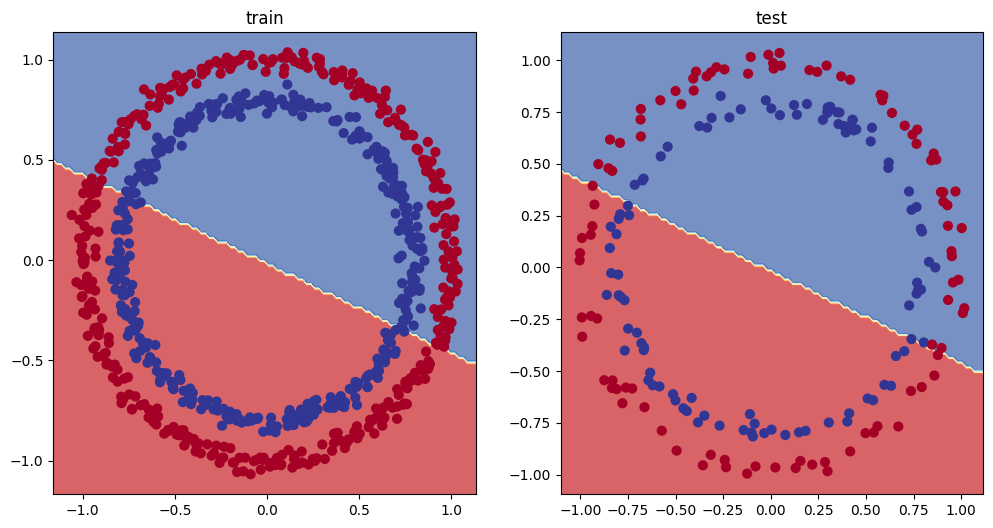

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_2, X_test, y_test)

In [83]:
#this model doesn't work well, lets imporve it next